```markdown
# To do list
- [ ] Create helper functions for cost functions 
- [ ] Learn about grid search
- [ ] Try
```

In [2]:
from utils import *

2024-06-26 17:40:18.539494: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Generate sample polymers 
# Define parameters 
num_monomers = 100 
mean_bond_length = 1
std_bond_length = 20
gaussian_noise_std = 10

num_templates = 100
total_polymers = 10000
num_observation_list = np.int32(np.linspace(10, 1000, num_templates))
# num_observation_list = np.int32(np.ones(num_templates)) * 100

template_chain_list = [generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length) for i in range(num_templates)]
observation_list = [generate_observations(c, n, gaussian_noise_std) for c, n in zip(template_chain_list, num_observation_list)]

observation_list = np.concatenate([*observation_list])
labels_true = np.concatenate([[i for _ in range(j)] for i, j in enumerate(num_observation_list)])
observation_flatten = np.array([squareform(pdist(x)).flatten() for x in observation_list])

In [3]:
X = np.array([squareform(pdist(x)).flatten() for x in observation_list])
Y = np.concatenate([[i for _ in range(j)] for i, j in enumerate(num_observation_list)])

# Shuffle data 
indices = np.arange(Y.shape[0])
np.random.shuffle(indices)
X_, Y_ = X[indices], Y[indices]

In [4]:
# Train the model using Bayesian gaussian mixture model 
n_comp = 120

# Create and fit the Bayesian Gaussian Mixture Model
bgmm = BayesianGaussianMixture(
    n_components=n_comp,      # Maximum number of components
    covariance_type='diag', # Type of covariance parameters
    max_iter=5000,         # Maximum number of iterations
    init_params='k-means++', # Method of initialization
    n_init=1,
    verbose=3
)

In [5]:
bgmm.fit(X)

Initialization 0
Initialization converged: True	 time lapse 71.10562s	 ll -39538396775.36759


BayesianGaussianMixture(covariance_type='diag', max_iter=5000, n_components=120,
                        verbose=3)

In [6]:
true_means = [squareform(pdist(x)).flatten() for x in template_chain_list]
pred_means = bgmm.means_

In [44]:
import itertools
import pickle
from multiprocessing import Pool

In [56]:
 # Helper function for generate_dataset function
 def generate_dataset_parallel(combo):
    num_monomers, mean_bond_length, std_bond_length, num_templates, weight_dist, noise_std, num_observations, num_dataset, _ = combo[0]
    save_dir = combo[1]
    for idx_dataset in range(num_dataset):
        # Generate template chains 
        template_chain_list = [generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length) for i in range(num_templates)]
        
        # Generate observations based on weight distribution, num_observations, and noise std
        # Calculate the concentration parameter alpha based on weight_dist
        # When weight_dist is 0, alpha should be very small (resulting in more uneven numbers)
        # When weight_dist is 1, alpha should be large (resulting in more even numbers)
        alpha = np.maximum(np.ones(num_templates) * weight_dist * 15, np.ones(num_templates)) 
        num_observation_list = np.int32(alpha * num_observations)
        observation_list = [generate_observations(c, n, noise_std) for c, n in zip(template_chain_list, num_observation_list)]
        
        # Concatenate observation_list into a single array
        observation_list = np.concatenate([*observation_list])
        labels_true = np.concatenate([[i for _ in range(j)] for i, j in enumerate(num_observation_list)])
        
        # Create a pickle file to save the dataset
        pickle_file = save_dir + f"dataset_{num_monomers}_{mean_bond_length}_{std_bond_length}_{num_templates}_{weight_dist}_{noise_std}_{num_observations}_{idx_dataset}.pkl"
        # If the file already exists, continue
        if os.path.exists(pickle_file):
            continue
        with open(pickle_file, 'wb') as f:
            pickle.dump({
                'template_chain_list': template_chain_list,
                'observation_list': observation_list,
                'labels': labels_true
            }, f)

# Define a function that generate a dataset of polymer chains 
# Save structures and labels in a pickle file 
# Vary the following parameters 
# Number of groups, weights distribution, Gaussian_noise_std 
def generate_dataset(params_dict: dict) -> None:
    """
    Generate a dataset of polymer chains with different parameters. 
    
    The dataset will be saved at `save_dir` as pickle files with README.txt file containing the parameters used to generate the dataset.
    

    Parameters
    ----------
    params_dict : dict 
        A dictionary where keys are parameter names and values are lists of parameter values.
        The expected keys and their corresponding values are:
        
        - 'num_monomers' : a list of single int
            Number of monomers in each polymer chain. Example: 100
        - 'mean_bond_length' : a list of a single float
            Mean bond length of the polymer chain. Example: 1.0
        - 'std_bond_length' : a list of a single float
            Standard deviation of the bond length of the polymer chain. Example: 0.1
        - 'num_templates' : ArrayLike of int
            Number of template polymers used to generate the dataset. Example: [10, 20, 30]
        - 'weights_dist' : ArrayLike of float between 0 and 1
            Degree of evenness for weight distribution (0 for uneven, 1 for even). Example: [0.1, 0.2, 0.3]
        - 'noise_std' : ArrayLike of float
            Standard deviation of the Gaussian noise used to generate observations from each template. Example: [0.1, 0.2, 0.3]
        - 'num_observations' : a list of a single int
            Total number of polymers generated in the dataset. Example: 1000
        - 'num_datasets' : a list of a single int
            Number of datasets to generate. Example: 1 
        - 'save_dir': a list of a single str
            Directory to save the dataset. Example: 'data/'

            
    Notes:
    ------
    This function generates a combinatorial dataset of polymers based on the provided parameter values.
    Ensure that the values for each parameter are provided as lists.
    """
    # Check number of CPU cores
    n_cores = os.cpu_count()
    if n_cores > 1:
        print(f"Using {n_cores} cores to generate the dataset.")
    else:
        print("Using 1 core to generate the dataset.")
    
    
    # Extract names and values of parameters 
    param_names = list(params_dict.keys())
    param_values = list(params_dict.values()) 
    
    # Check if all the parameters are provided
    assert len(param_names) == 9, "Please provide all the parameters"
    
    # Generate all possible combinations of parameter values without save_dir
    param_combinations = list(itertools.product(*param_values))
    
    # Create the save directory if it does not exist
    save_dir = params_dict['save_dir'][0]
    # Make sure the save_dir ends with a '/'
    if not save_dir.endswith('/'):
        save_dir += '/'
        
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    # If it already exists, create a warning
    else:
        print(f"Warning: {save_dir} already exists. Files may be overwritten.")
        
    # Write the README.txt file containing the parameters used to generate the dataset
    with open(save_dir + 'README.txt', 'w') as f:
        f.write("Parameters used to generate the dataset:\n")
        for name, value in zip(param_names, param_values):
            f.write(f"{name}: {value}\n")
    
    # Create the dataset from the parameter combinations
    if n_cores == 1:
        for combo in tqdm(param_combinations):
            num_monomers, mean_bond_length, std_bond_length, num_templates, weight_dist, noise_std, num_observations, num_dataset, _ = combo
                
            for idx_dataset in range(num_dataset):
                # Generate template chains 
                template_chain_list = [generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length) for i in range(num_templates)]
                
                # Generate observations based on weight distribution, num_observations, and noise std
                # Calculate the concentration parameter alpha based on weight_dist
                # When weight_dist is 0, alpha should be very small (resulting in more uneven numbers)
                # When weight_dist is 1, alpha should be large (resulting in more even numbers)
                alpha = np.maximum(np.ones(num_templates) * weight_dist * 15, np.ones(num_templates)) 
                num_observation_list = np.int32(alpha * num_observations)
                observation_list = [generate_observations(c, n, noise_std) for c, n in zip(template_chain_list, num_observation_list)]
                
                # Concatenate observation_list into a single array
                observation_list = np.concatenate([*observation_list])
                labels_true = np.concatenate([[i for _ in range(j)] for i, j in enumerate(num_observation_list)])
                
                # Create a pickle file to save the dataset
               
                
                pickle_file = save_dir + f"dataset_{num_monomers}_{mean_bond_length}_{std_bond_length}_{num_templates}_{weight_dist}_{noise_std}_{num_observations}_{idx_dataset}.pkl"
                # Check if the file exists, if exists continue
                if os.path.exists(pickle_file):
                    continue 
                with open(pickle_file, 'wb') as f:
                    pickle.dump({
                        'template_chain_list': template_chain_list,
                        'observation_list': observation_list,
                        'labels': labels_true
                    }, f)
    else:
        # Use parallel processing to generate the dataset
       
        # Prepare the arguments for the function
        args = [(combo, save_dir) for combo in param_combinations]
        
        # Using Pool with imap_unordered for progress tracking
        with Pool(n_cores) as p:
            list(tqdm(p.imap_unordered(generate_dataset_parallel, args), total=len(args)))
            
    # Create a csv file for mapping parameter combos to pickle files
    with open(save_dir + 'parameter_mapping.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(param_names + ['pickle_file'])
        for combo in param_combinations:
            num_dataset = combo[7]
            for idx_dataset in range(num_dataset):
                pickle_file = save_dir + f"dataset_{combo[0]}_{combo[1]}_{combo[2]}_{combo[3]}_{combo[4]}_{combo[5]}_{combo[6]}_{combo[7]}.pkl"
                writer.writerow(list(combo) + [pickle_file])
    
    # Print a message to indicate that the dataset has been generated
    print(f"Dataset generated and saved at {save_dir}")
        
    

In [57]:
params_dict = {
    'num_monomers': [100],
    'mean_bond_length': [10],
    'std_bond_length': [20],
    'num_templates': [2, 3, 5, 10, 50, 100, 250, 500],
    'weights_dist': [0, 1, 1000],
    'gaussian_noise_std': np.array([0.1, 0.5, 1, 1.5, 2, 5]) * 20,
    'num_observations': [10000],
    'num_datasets': [10000],
    'save_dir': ['/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240625']
}

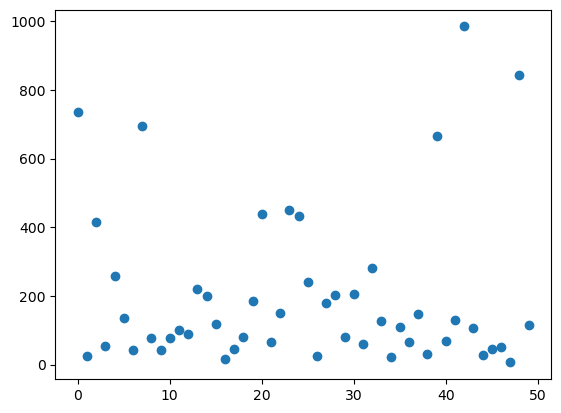

In [147]:
weight_dist = 0

num_templates = 50
num_observations = 10000
alpha = np.maximum(np.ones(num_templates) * weight_dist * 100, np.ones(num_templates)) 
num_observation_list = np.int32(np.random.dirichlet(alpha) * num_observations)
plt.plot(num_observation_list, 'o')

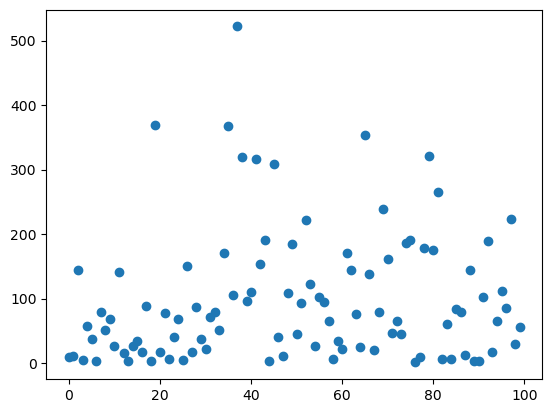

In [174]:
# Generate template chains 
template_chain_list = [generate_gaussian_chain(num_monomers=100, mean_bond_length=10, std_bond_length=20) for i in range(num_templates)]

# Generate observations based on weight distribution, num_observations, and noise std
# Calculate the concentration parameter alpha based on weight_dist
# When weight_dist is 0, alpha should be very small (resulting in more uneven numbers)
# When weight_dist is 1, alpha should be large (resulting in more even numbers)
weight_dist = 0
noise_std = 20
num_templates = 100
num_observations = 10000
alpha = np.maximum(np.ones(num_templates) * weight_dist * 100, np.ones(num_templates)) 
num_observation_list = np.int32(np.random.dirichlet(alpha) * num_observations)
plt.plot(num_observation_list, 'o')
observation_list = [generate_observations(c, n, noise_std) for c, n in zip(template_chain_list, num_observation_list)]
# Concatenate observation_list into a single array
observation_list = np.concatenate([*observation_list])
labels_true = np.concatenate([[i for _ in range(j)] for i, j in enumerate(num_observation_list)])

In [ ]:
generate_dataset(params_dict)

In [178]:
def generate_observations(polymer_chain: ArrayLike, 
                          num_observations: int, 
                          gaussian_noise_std: float) -> list:
    """ Given a template `polymer_chain`, generate `num_observations` polymer chains by adding 
    some gaussian noise with zero mean and `gaussian_noise_std` standard deviation to the 
    `polymer_chain`
    
    Parameters
    ----------
    polymer_chain : ArrayLike
                   an `(num_monomers-by-3)` array containing the monomer coordinates
    num_observations : int
                       a number of independent observations generated by this function 
    gaussian_noise_std : float
                         the standard deviation for the gaussian noise to be used to generate observations
    
    Returns
    ------
    list of numpy.ndarray 
        a list of `num_obervations` numpy.ndarray with the same shape as `polymer_chain` 
    """
    observation_list = []
    polymer_size = polymer_chain.shape 
    
    # Parameters for Gaussian noise 
    mean = 0 
    std = gaussian_noise_std
    
    for i in range(num_observations):
        # Generate Gaussian Noise 
        noise = np.random.normal(mean, std, polymer_size)
        
        # Add noise to the original data
        noisy_data = polymer_chain + noise 
        
        # Append this observation to the list
        observation_list.append(noisy_data)
    
    return observation_list

# Helper function for generate_dataset function
def generate_dataset_parallel(combo):
    num_monomers, mean_bond_length, std_bond_length, num_templates, weight_dist, noise_std, num_observations, num_dataset, _ = combo[0]
    save_dir = combo[1]
    
    dataset_list = []
    for idx_dataset in range(num_dataset):
        # Generate template chains 
        template_chain_list = [generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length) for i in range(num_templates)]
        
        # Generate observations based on weight distribution, num_observations, and noise std
        # Calculate the concentration parameter alpha based on weight_dist
        # When weight_dist is 0, alpha should be very small (resulting in more uneven numbers)
        # When weight_dist is 1, alpha should be large (resulting in more even numbers)
        alpha = np.maximum(np.ones(num_templates) * weight_dist * 100, np.ones(num_templates)) 
        num_observation_list = np.int32(np.random.dirichlet(alpha) * num_observations) + 1
        observation_list = [generate_observations(c, n, noise_std) for c, n in zip(template_chain_list, num_observation_list)]
        
        # Concatenate observation_list into a single array
        observation_list = np.concatenate([*observation_list])
        labels_true = np.concatenate([[i for _ in range(j)] for i, j in enumerate(num_observation_list)])
        
        dataset_list.append({
                'template_chain_list': template_chain_list,
                'observation_list': observation_list,
                'labels': labels_true
            })
        
    # Create a pickle file to save the dataset
    pickle_file = save_dir + f"dataset_{num_monomers}_{mean_bond_length}_{std_bond_length}_{num_templates}_{weight_dist}_{noise_std}_{num_observations}.pkl"
    tmp_file = pickle_file + '.tmp'
    # If the file already exists, continue
    if os.path.exists(pickle_file) or os.path.exists(tmp_file):
        continue
    
    with open(tmp_file, 'wb') as f:
        pickle.dump(dataset_list, f)
    os.rename(tmp_file, pickle_file)

# Define a function that generate a dataset of polymer chains 
# Save structures and labels in a pickle file 
# Vary the following parameters 
# Number of groups, weights distribution, Gaussian_noise_std 
def generate_dataset(params_dict: dict) -> None:
    """
    Generate a dataset of polymer chains with different parameters. 
    
    The dataset will be saved at `save_dir` as pickle files with README.txt file containing the parameters used to generate the dataset.
    

    Parameters
    ----------
    params_dict : dict 
        A dictionary where keys are parameter names and values are lists of parameter values.
        The expected keys and their corresponding values are:
        
        - 'num_monomers' : a list of single int
            Number of monomers in each polymer chain. Example: 100
        - 'mean_bond_length' : a list of a single float
            Mean bond length of the polymer chain. Example: 1.0
        - 'std_bond_length' : a list of a single float
            Standard deviation of the bond length of the polymer chain. Example: 0.1
        - 'num_templates' : ArrayLike of int
            Number of template polymers used to generate the dataset. Example: [10, 20, 30]
        - 'weights_dist' : ArrayLike of float between 0 and 1
            Degree of evenness for weight distribution (0 for uneven, 1 for even). Example: [0.1, 0.2, 0.3]
        - 'noise_std' : ArrayLike of float
            Standard deviation of the Gaussian noise used to generate observations from each template. Example: [0.1, 0.2, 0.3]
        - 'num_observations' : a list of a single int
            Total number of polymers generated in the dataset. Example: 1000
        - 'num_datasets' : a list of a single int
            Number of datasets to generate. Example: 1 
        - 'save_dir': a list of a single str
            Directory to save the dataset. Example: 'data/'

            
    Notes:
    ------
    This function generates a combinatorial dataset of polymers based on the provided parameter values.
    Ensure that the values for each parameter are provided as lists.
    """
    # Check number of CPU cores
    n_cores = os.cpu_count()
    if n_cores > 1:
        print(f"Using {n_cores} cores to generate the dataset.")
    else:
        print("Using 1 core to generate the dataset.")
    
    
    # Extract names and values of parameters 
    param_names = list(params_dict.keys())
    param_values = list(params_dict.values()) 
    
    # Check if all the parameters are provided
    assert len(param_names) == 9, "Please provide all the parameters"
    
    # Generate all possible combinations of parameter values without save_dir
    param_combinations = list(itertools.product(*param_values))
    
    # Create the save directory if it does not exist
    save_dir = params_dict['save_dir'][0]
    # Make sure the save_dir ends with a '/'
    if not save_dir.endswith('/'):
        save_dir += '/'
        
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    # If it already exists, create a warning
    else:
        print(f"Warning: {save_dir} already exists. Files may be overwritten.")
        
    # Write the README.txt file containing the parameters used to generate the dataset
    with open(save_dir + 'README.txt', 'w') as f:
        f.write("Parameters used to generate the dataset:\n")
        for name, value in zip(param_names, param_values):
            f.write(f"{name}: {value}\n")
    
    # Create the dataset from the parameter combinations
    if n_cores == 1:
        for combo in tqdm(param_combinations):
            num_monomers, mean_bond_length, std_bond_length, num_templates, weight_dist, noise_std, num_observations, num_dataset, _ = combo
            
            dataset_list = []
            for idx_dataset in range(num_dataset):
                # Generate template chains 
                template_chain_list = [generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length) for i in range(num_templates)]
                
                # Generate observations based on weight distribution, num_observations, and noise std
                # Calculate the concentration parameter alpha based on weight_dist
                # When weight_dist is 0, alpha should be very small (resulting in more uneven numbers)
                # When weight_dist is 1, alpha should be large (resulting in more even numbers)
                alpha = np.maximum(np.ones(num_templates) * weight_dist * 100, np.ones(num_templates)) 
                num_observation_list = np.int32(np.random.dirichlet(alpha) * num_observations) + 1
                observation_list = [generate_observations(c, n, noise_std) for c, n in zip(template_chain_list, num_observation_list)]
                
                # Concatenate observation_list into a single array
                observation_list = np.concatenate([*observation_list])
                labels_true = np.concatenate([[i for _ in range(j)] for i, j in enumerate(num_observation_list)])
                
                dataset_list.append({
                        'template_chain_list': template_chain_list,
                        'observation_list': observation_list,
                        'labels': labels_true
                    })
                
            # Create a pickle file to save the dataset
            pickle_file = save_dir + f"dataset_{num_monomers}_{mean_bond_length}_{std_bond_length}_{num_templates}_{weight_dist}_{noise_std}_{num_observations}.pkl"
            tmp_file = pickle_file + '.tmp'
            # If the file already exists, continue
            if os.path.exists(pickle_file) or os.path.exists(tmp_file):
                continue
            
            with open(tmp_file, 'wb') as f:
                pickle.dump(dataset_list, f)
            os.rename(tmp_file, pickle_file)
    else:
        # Use parallel processing to generate the dataset
       
        # Prepare the arguments for the function
        args = [(combo, save_dir) for combo in param_combinations]
        
        # Using Pool with imap_unordered for progress tracking
        with Pool(n_cores) as p:
            list(tqdm(p.imap_unordered(generate_dataset_parallel, args), total=len(args)))
            
    # Create a csv file for mapping parameter combos to pickle files
    with open(save_dir + 'parameter_mapping.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(param_names + ['pickle_file'])
        for combo in param_combinations:
            num_dataset = combo[7]
            for idx_dataset in range(num_dataset):
                pickle_file = save_dir + f"dataset_{combo[0]}_{combo[1]}_{combo[2]}_{combo[3]}_{combo[4]}_{combo[5]}_{combo[6]}_{combo[7]}.pkl"
                writer.writerow(list(combo) + [pickle_file])
    
    # Print a message to indicate that the dataset has been generated
    print(f"Dataset generated and saved at {save_dir}")

In [179]:
params_dict = {
        'num_monomers': [100],
        'mean_bond_length': [10],
        'std_bond_length': [20],
        'num_templates': [100],
        'weights_dist': [0],
        'gaussian_noise_std': np.array([ 1]) * 20,
        'num_observations': [10000],
        'num_datasets': [1000],
        'save_dir': ['/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240626/']
    }

generate_dataset(params_dict)

Using 40 cores to generate the dataset.


  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

List of potential cost and score functions
1. log-likelihood (available on sklearn) for overall fit
2. MSE for means 
3. Frobenius norm for covariances
4. KL-divergence for weights 
5. AMI ffor clustering performance

In [7]:
true_means = np.array(true_means)
pred_means = np.array(pred_means)

In [10]:
mean_true_assigned, mean_pred_assigned = assign_clusters(true_means, pred_means)

In [11]:
true_idx, pred_idx = assign_clusters(true_means, pred_means, True)

In [12]:
true_covs = [np.var(X[Y == i], axis=0) for i in true_idx]
pred_covs = np.array(bgmm.covariances_)[pred_idx]

In [20]:
MSD_covariances(true_covs, pred_covs)

33572.31472401351

In [19]:
np.mean(np.mean((mean_true_assigned - mean_pred_assigned)**2, axis=1))

147.5134242486001

In [22]:
MSE_means(mean_true_assigned, mean_pred_assigned)

147.51342424860005

In [25]:
KL_div_weights(true_weights, pred_weights)

0.005242655495041124

In [18]:
corr_covariances(true_covs, pred_covs)

0.18860149324600414

In [15]:
true_weights = np.array([np.sum(Y == i) for i in true_idx]) / len(Y)
pred_weights = bgmm.weights_[pred_idx]

In [16]:
corr_weights(true_weights, pred_weights)

0.9995178787073087

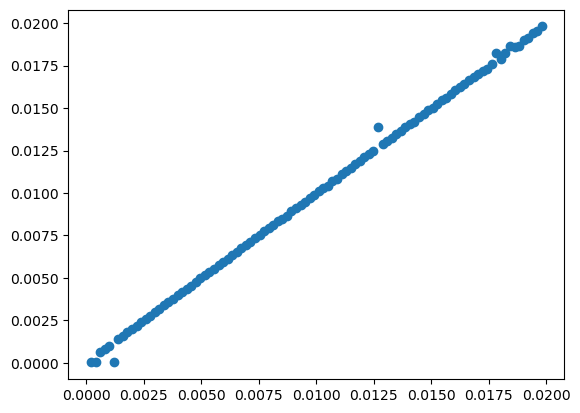

In [17]:
plt.plot(true_weights, pred_weights, 'o')

In [2]:
# Test load dataset and extract parameters 
# Train on bgmm with specific hyperparameters
# Evaluate performances using score and loss functions defined above 

# First define the function to assign clusters to the predicted weights
# based on the minimum distance between true_means and pred_means
def assign_clusters(mean_true, mean_pred, index=False):
    """
    Assigns clusters to the true and predicted means based on the minimum distance between them.

    Parameters
    ----------
    mean_true : numpy.ndarray
        Array of true means.
    mean_pred : numpy.ndarray
        Array of predicted means.
    index : bool, optional
        Flag indicating whether to return the row and column indices of the sorted mean_true and mean_pred. Default is False.

    Returns
    -------
    tuple
        If index is False, returns a tuple of sorted mean_true and sorted mean_pred based on minimum distance.
        If index is True, returns a tuple of row and column indices of the sorted mean_true and mean_pred.
    """

    # Calculate the pairwise distance between the true and predicted means
    pred_error_mat = cdist(mean_pred, mean_true)

    # Assign the predicted weights to the true weights based on the minimum distance
    row_ind, col_ind = linear_sum_assignment(pred_error_mat)

    # if index flag is False, return the sorted mean_true and sorted mean_pred based on minimum distance
    if not index:
        return mean_true[col_ind], mean_pred[row_ind]
    # if index flag is True, return the row and column indices of the sorted mean_true and mean_pred
    else:
        return col_ind, row_ind

def MSE_means(mean_true_assigned, mean_pred_assigned):
    """
    Calculate the mean squared error between the true and predicted means.
    
    These true and predicted means have been assigned cluster based on the pairwise distance between them.

    Parameters
    ----------
    mean_true_assigned : array-like
        The true means assigned.
    mean_pred_assigned : array-like
        The predicted means assigned.

    Returns
    -------
    mse : float
        The mean squared error between the true and predicted means.
        
    See Also
    --------
    assign_clusters : Assigns clusters to the true and predicted means based on the minimum distance between them.

    """

    # Ensure that the mean_true and mean_pred are numpy arrays
    mean_true = np.array(mean_true_assigned)
    mean_pred = np.array(mean_pred_assigned)
    
    # Calculate the mean squared error between the true and predicted means
    mse = np.mean((mean_true_assigned - mean_pred_assigned)**2, axis=(1, 0))
    
    return mse

# KL divergence for weights 
def KL_div_weights(weights_true_assigned, weights_pred_assigned):
    """
    Calculates the Kullback-Leibler (KL) divergence between the true and predicted weights.

    Parameters
    ----------
    weights_true : ArrayLike of float
        The true weights of the components. These true weights have already been assigned groups.
    weights_pred : ArrayLike of float
        The predicted weights of the components. These predicted weights have already been assigned groups.
        
    Returns
    -------
    kl_div (float): The KL divergence between the true and predicted weights.
    """
    
    # Ensure that the weights_true and weights_pred are numpy arrays
    weights_true = np.array(weights_true_assigned)
    weights_pred = np.array(weights_pred_assigned)
    
    # Calculate the KL divergence between the true and predicted weights
    kl_div = np.sum(weights_true_assigned * np.log(weights_true_assigned / weights_pred_assigned))
    
    return kl_div

# Frobenius norm for covariance matrices
def MSD_covariances(covariances_true_assigned, covariances_pred_assigned):
    """
    Calculate the Frobenius norm of the difference between the true and predicted covariances.
    
    These true and predicted covariances have been assigned cluster based on the pairwise distance between them.

    Parameters
    ----------
    covariances_true_assigned : array-like
        The flattened true covariances assigned.
    covariances_pred_assigned : array-like
        The flattened predicted covariances assigned.

    Returns
    -------
    mse : float
        The mean squared error between the true and predicted covariances.
        
        
    See Also
    --------
    assign_clusters : Assigns clusters to the true and predicted covariances based on the minimum distance between them.

    """
    # Ensure that the covariances_true and covariances_pred are numpy arrays
    covariances_true_assigned = np.array(covariances_true_assigned)
    covariances_pred_assigned = np.array(covariances_pred_assigned)
    
    # Calculate the mean squared error between the true and predicted covariances
    mse = np.mean((covariances_true_assigned - covariances_pred_assigned)**2, axis=(1, 0))
    
    return mse

def corr_covariances(covariances_true_assigned, covariances_pred_assigned):
    """
    Calculate the correlation between the true and predicted covariances.

    These true and predicted covariances have been assigned cluster based on the pairwise distance between them.

    Parameters
    ----------
    covariances_true_assigned : array-like
        The flattened true covariances assigned.
    covariances_pred_assigned : array-like
        The flattened predicted covariances assigned.

    Returns
    -------
    corr : float
        The correlation between the true and predicted covariances.
        
        
    See Also
    --------
    assign_clusters : Assigns clusters to the true and predicted covariances based on the minimum distance between them.

    """
    # Ensure that the covariances_true and covariances_pred are numpy arrays
    covariances_true_assigned = np.array(covariances_true_assigned)
    covariances_pred_assigned = np.array(covariances_pred_assigned)
    
    # Calculate the correlation between the true and predicted covariances
    corr = np.corrcoef(covariances_true_assigned, covariances_pred_assigned)[0, 1]
    
    return corr

def corr_weights(weights_true_assigned, weights_pred_assigned):
    """
    Calculate the correlation between the true and predicted weights.
    
    These true and predicted weights have been assigned cluster based on the pairwise distance between them.

    Parameters
    ----------
    weights_true_assigned : array-like
        The true weights assigned.
    weights_pred_assigned : array-like
        The predicted weights assigned.

    Returns
    -------
    corr : float
        The correlation between the true and predicted weights.
        
        
    See Also
    --------
    assign_clusters : Assigns clusters to the true and predicted weights based on the minimum distance between them.

    """
    # Ensure that the weights_true and weights_pred are numpy arrays
    weights_true_assigned = np.array(weights_true_assigned)
    weights_pred_assigned = np.array(weights_pred_assigned)
    
    # Calculate the correlation between the true and predicted weights
    corr = np.corrcoef(weights_true_assigned, weights_pred_assigned)[0, 1]
    
    return corr

In [ ]:
# Computational pipeline 
# Each slurm file, load one dataset, fit, and then save the quality of the fit in txt file

In [4]:
def load_dataset(pickle_file):
    """
    Load the dataset from the pickle file.

    Parameters
    ----------
    pickle_file : str
        The path to the pickle file containing the dataset.

    Returns
    -------
    tuple
        A tuple of the observation list, the true labels, and a dictionary of parameters.

    Raises
    ------
    FileNotFoundError
        If the pickle file does not exist.

    Notes
    -----
    This function loads the dataset from a pickle file. The pickle file should contain a tuple
    with the observation list and the true labels. It also extracts parameters from the file name
    and puts them in a dictionary.

    Example
    -------
    >>> pickle_file = 'data.pickle'
    >>> observation_list, labels_true, param_dict = load_dataset(pickle_file)
    """

    with open(pickle_file, 'rb') as f:
        dataset_dict = pickle.load(f)
        template_list = dataset_dict['template_chain_list']
        observation_list = dataset_dict['observation_list']
        labels_true = dataset_dict['labels']
        
    # Extract parameters from file name
    # Remove .pkl file suffix
    pickle_file = pickle_file.replace('.pkl', '')
    params = os.path.basename(pickle_file).split('_')[1:]
    params = [int(p) if p.isdigit() else float(p) for p in params]

    # Put the parameters in a dictionary
    param_dict = {
        'num_monomers': params[0],
        'mean_bond_length': params[1],
        'std_bond_length': params[2],
        'num_templates': params[3],
        'weights_dist': params[4],
        'noise_std': params[5],
        'num_observations': params[6],
        'idx_dataset': params[7]
    }
        
    return template_list, observation_list, labels_true, param_dict

def fit_bgmm(observation_list, n_comp=120):
    """
    Fits a Bayesian Gaussian Mixture Model (BGMM) to the given observation list.

    Parameters
    ----------
    observation_list : array-like
        The list of observations to fit the BGMM to.
    n_comp : int, optional
        The maximum number of components in the BGMM. Default is 120.

    Returns
    -------
    bgmm : BayesianGaussianMixture
        The fitted BGMM model.
    """

    bgmm = BayesianGaussianMixture(
        n_components=n_comp,      # Maximum number of components
        covariance_type='diag', # Type of covariance parameters
        max_iter=1000,         # Maximum number of iterations
        init_params='k-means++', # Method of initialization
        n_init=1
    )

    bgmm.fit(observation_list)
    
    return bgmm

In [6]:
# Test load dataset and extract parameters
pickle_file = '/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240625/dataset_100_10_20_2_0.1_2.0_10000_0.pkl'
template_list, X_, Y_, param_dict = load_dataset(pickle_file)

In [7]:
observation_list = [squareform(pdist(x)).flatten() for x in X_]

In [8]:
bgmm_ = fit_bgmm(observation_list)

In [12]:
true_weights = np.array([np.sum(Y_ == i) for i in np.unique(Y_)]) / len(Y_)

In [13]:
true_means = [squareform(pdist(x)).flatten() for x in template_list]
true_covs = [np.var(X_[Y_ == i], axis=0) for i in np.unique(Y_)]

In [9]:
pred_means = bgmm_.means_
pred_covs = bgmm_.covariances_
pred_weights = bgmm_.weights_

In [14]:
true_idx, pred_idx = assign_clusters(true_means, pred_means, True)

(0.0, 1.0)

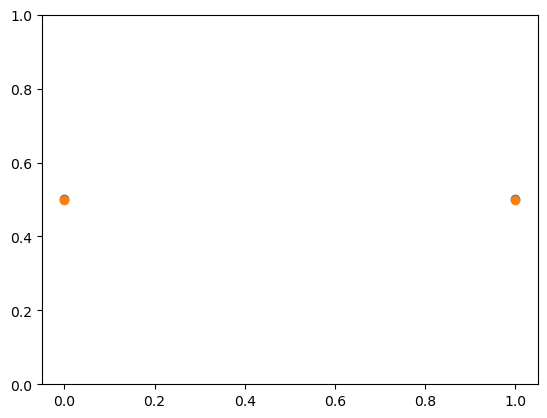

In [18]:
plt.plot(true_weights[true_idx], 'o')
plt.plot(pred_weights[pred_idx], 'o')
plt.ylim([0, 1])

In [57]:
# Define a function to evaluate the performance of the BGMM model
def evaluate_bgmm(pickle_file):
    """
    Evaluate the performance of the Bayesian Gaussian Mixture Model (BGMM) on a given dataset.

    Parameters:
    - pickle_file (str): The path to the pickle file containing the dataset.

    Returns:
    - performance_dict (dict): A dictionary containing the performance metrics of the BGMM model.
        - mean_mse (float): The mean squared error between the true and predicted means.
        - cov_mse (float): The mean squared error between the true and predicted covariances.
        - cov_corr (float): The correlation between the true and predicted covariances.
        - weight_corr (float): The correlation between the true and predicted weights.
        - weight_kl (float): The KL divergence between the true and predicted weights.
        - log_likelihood (float): The log-likelihood of the model.
        - ami_score (float): The adjusted mutual information score of the model.
    """
    
    # Load data from pickle path
    template_list, X, label_list, param_dict = load_dataset(pickle_file)
    observation_list = [squareform(pdist(x)).flatten() for x in X]
    
    # Fit the BGMM model
    fitted_bgmm = fit_bgmm(observation_list)
    
    # Make sure that all input lists are numpy arrays
    template_list = np.array(template_list)
    observation_list = np.array(observation_list)
    label_list = np.array(label_list)
    
    # Extract the means, covariances, and weights from the fitted BGMM model
    pred_means = fitted_bgmm.means_
    pred_covs = fitted_bgmm.covariances_
    pred_weights = fitted_bgmm.weights_
    
    # Assign the clusters based on the minimum distance between the true and predicted means
    true_means = np.array([squareform(pdist(x)).flatten() for x in template_list])
    true_covs = np.array([np.var(observation_list[label_list == i], axis=0) for i in np.unique(label_list)])
    true_weights = np.array([np.sum(label_list == i) for i in np.unique(label_list)]) / len(label_list)
    true_idx, pred_idx = assign_clusters(true_means, pred_means, True)
    
    # Calculate the mean squared error between the true and predicted means
    mean_mse = MSE_means(true_means[true_idx], pred_means[pred_idx])
    
    # Calculate the mean squared error between the true and predicted covariances
    cov_mse = MSD_covariances(true_covs[true_idx], pred_covs[pred_idx])
    
    # Calculate the correlation between the true and predicted covariances
    cov_corr = corr_covariances(true_covs[true_idx], pred_covs[pred_idx])
    
    # Calculate the correlation between the true and predicted weights
    weight_corr = corr_weights(true_weights[true_idx], pred_weights[pred_idx])
    
    # Calculate the KL divergence between the true and predicted weights
    weight_kl = KL_div_weights(true_weights[true_idx], pred_weights[pred_idx])
    
    # Calculate the log-likelihood of the model
    log_likelihood = fitted_bgmm.score(observation_list)
    
    # Calculate the AMI score of the model
    ami_score = adjusted_mutual_info_score(label_list, fitted_bgmm.predict(observation_list))
    
    # Save the performance metrics in a dictionary
    performance_dict = {
        'mean_mse': mean_mse,
        'cov_mse': cov_mse,
        'cov_corr': cov_corr,
        'weight_corr': weight_corr,
        'weight_kl': weight_kl,
        'log_likelihood': log_likelihood,
        'ami_score': ami_score
    }
    
    # Generate a new folder to save the results
    # Check if the folder already exists
    split_path = pickle_file.split('/')
    pickle_fname = split_path[-1]
    result_dir = '/'.join(split_path[:-1]) + '/results/'
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    
    
    # Write this dictionary to a csv file 
    # Columns names include the parameters used to generate the dataset
    # and the performance metrics
    # The file name should be the same as the pickle file with .txt extension
    
    fname = result_dir + pickle_fname.replace('.pkl', '.txt')
    with open(fname, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(list(param_dict.keys()) + list(performance_dict.keys()))
        writer.writerow(list(param_dict.values()) + list(performance_dict.values()))
    
    # return the performance metrics
    return performance_dict

In [187]:
pickle_file = '/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240626/dataset_100_10_20_500_1000_40.0_10000_332.pkl'

In [188]:
import psutil
# Monitor memory usage before fitting
process = psutil.Process()
mem_before = process.memory_info().rss / 1024 ** 2  # Memory in MB
performance_dict = evaluate_bgmm(pickle_file)
# Monitor memory usage after fitting
mem_after = process.memory_info().rss / 1024 ** 2  # Memory in MB


In [189]:
print(f"Memory usage before fitting: {mem_before:.2f} MB")
print(f"Memory usage after fitting: {mem_after:.2f} MB")
print(f"Memory usage increased by: {mem_after - mem_before:.2f} MB")

Memory usage before fitting: 5183.94 MB
Memory usage after fitting: 5183.94 MB
Memory usage increased by: 0.00 MB


In [52]:
from sklearn.metrics import adjusted_mutual_info_score
import csv 
performance_dict = evaluate_bgmm(bgmm_, template_list, observation_list, Y_, pickle_file, param_dict)

[0.5 0.5] [0.49815345 0.49792104]


/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [53]:
# load the csv file into panda dataframe
fname = '/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240625/results/dataset_100_10_20_2_0.1_2.0_10000_0.txt'
df = pd.read_csv(fname)

ModuleNotFoundError: No module named 'mpi4py'

In [54]:
df

,num_monomers,mean_bond_length,std_bond_length,num_templates,weights_dist,noise_std,num_observations,idx_dataset,mean_mse,cov_mse,cov_corr,weight_corr,weight_kl,log_likelihood,ami_score
0,100,10,20,2,0.1,2.0,10000,0,0.005661,8.196156,0.983166,NaN,0.003933,-25472.080287,1.0


In [55]:
os.getenv('USER')

'tudomlumleart'

In [3]:
import os
import pickle
import subprocess
import time


def load_pickle_files_and_submit_jobs(directory, sleep_interval=10):
    processed_files = set()

    def get_current_job_count():
        result = subprocess.run(['squeue', '-u', os.getenv('USER')], stdout=subprocess.PIPE)
        job_lines = result.stdout.decode('utf-8').split('\n')
        return len(job_lines) - 1  # Subtracting 1 to exclude the header line
    
    def submit_job(pickle_file):
        slurm_path = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/scripts/slurm/20240625_AnalyzeBGMMfit.sh'
        subprocess.run(['sbatch', slurm_path, pickle_file])

    while True:
        # List all pickle files in the directory with full paths
        pickle_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.pkl')]
        
        # Check processed files in the results directory
        # List all files in the results directory with full paths
        # Change the file extension to .pkl for comparison with files in pickle_files
        results_dir = os.path.join(directory, 'results')
        processed_file_new = set([os.path.join(results_dir, f.replace('.txt', '.pkl')) for f in os.listdir(results_dir) if f.endswith('.txt')])
        processed_files |= processed_file_new

        # Filter out files that have already been processed
        new_files = [f for f in pickle_files if f not in processed_files]
        
        print('Number of new files: ', len(new_files))

        # If there are no new files and all files have been processed, break the loop
        if not new_files and all(f in processed_files for f in pickle_files):
            print("All files have been processed and no new files are found.")
            break

        # Submit jobs for new files
        # Submit 100 files at a time
        # Make sure that the number of jobs does not go over 50
        for fi in new_files:
            print(fi)
            # Check if the number of jobs is less than 50
            # print current time 
            print('Current time: ', time.ctime())
            print('Current job count: ', get_current_job_count())
            if get_current_job_count() < 50:
                submit_job(fi)
                processed_files.add(fi)
            # If the number of jobs is more than 50, break
            else:
                break

        time.sleep(sleep_interval)

        # We can write processed_files in text file somewhere to keep track of processed files

In [7]:
load_pickle_files_and_submit_jobs('/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240627/')

Number of new files:  105
/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240627/dataset_100_10_20_100_1000_40.0_10000.pkl
Current time:  Thu Jun 27 10:54:47 2024
Current job count:  2
Submitted batch job 3566550
/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240627/dataset_100_10_20_5_1000_2.0_10000.pkl
Current time:  Thu Jun 27 10:54:47 2024
Current job count:  3
Submitted batch job 3566551
/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240627/dataset_100_10_20_10_1000_10.0_10000.pkl
Current time:  Thu Jun 27 10:54:48 2024
Current job count:  4
Submitted batch job 3566552
/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240627/dataset_100_10_20_250_1000_40.0_10000.pkl
Current time:  Thu Jun 27 10:54:48 2024
Current job count:  5
Submitted batch job 3566553
/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240627/dataset_100_10_20_100_1000_2.0_10000.pkl
Current time:  Thu Jun 27 10:54:48 2024
Current job count:  6
Submitted batch job 35

KeyboardInterrupt: 

In [81]:
job_script = \
        f"""#!/bin/bash
        #SBATCH --job-name=modelFit
        #SBATCH --output=/mnt/home/tudomlumleart/ceph/job_outputs/modelFit_%j.out
        #SBATCH --error=/mnt/home/tudomlumleart/ceph/job_outputs/modelFit_%j.err
        #SBATCH --partition=ccm
        #SBATCH --nodes=1
        #SBATCH --ntasks=1
        #SBATCH --mem=20G
        #SBATCH --cpus-per-node=1
        #SBATCH --mail-type=FAIL
        #SBATCH --mail-user=tudomlumleart@flatironinstitute.org

        module load python 

        source /mnt/home/tudomlumleart/00_VirtualEnvironments/jupyter-gpu-openmm/bin/activate

        python /mnt/home/tudomlumleart/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/scripts/20240626_DetermineBGMMFit.py {pickle_file}
        """

In [82]:
job_script

'#!/bin/bash\n        #SBATCH --job-name=modelFit\n        #SBATCH --output=/mnt/home/tudomlumleart/ceph/job_outputs/modelFit_%j.out\n        #SBATCH --error=/mnt/home/tudomlumleart/ceph/job_outputs/modelFit_%j.err\n        #SBATCH --partition=ccm\n        #SBATCH --nodes=1\n        #SBATCH --ntasks=1\n        #SBATCH --mem=20G\n        #SBATCH --cpus-per-node=1\n        #SBATCH --mail-type=FAIL\n        #SBATCH --mail-user=tudomlumleart@flatironinstitute.org\n\n        module load python \n\n        source /mnt/home/tudomlumleart/00_VirtualEnvironments/jupyter-gpu-openmm/bin/activate\n\n        python /mnt/home/tudomlumleart/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/scripts/20240626_DetermineBGMMFit.py /mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240625/dataset_100_10_20_2_0.1_2.0_10000_0.pkl\n        '

In [2]:
import os
import pickle
import subprocess
import time
import argparse
from joblib import Parallel, delayed
from utils import *

def load_dataset(pickle_file):
    """
    Load the dataset from the pickle file.

    Parameters
    ----------
    pickle_file : str
        The path to the pickle file containing the dataset.

    Returns
    -------
    tuple
        A tuple of the observation list, the true labels, and a dictionary of parameters.

    Raises
    ------
    FileNotFoundError
        If the pickle file does not exist.

    Notes
    -----
    This function loads the dataset from a pickle file. The pickle file should contain a tuple
    with the observation list and the true labels. It also extracts parameters from the file name
    and puts them in a dictionary.

    Example
    -------
    >>> pickle_file = 'data.pickle'
    >>> observation_list, labels_true, param_dict = load_dataset(pickle_file)
    """
    with open(pickle_file, 'rb') as f:
        dataset_list = pickle.load(f)

        
    # Extract parameters from file name
    # Remove .pkl file suffix
    pickle_file = pickle_file.replace('.pkl', '')
    params = os.path.basename(pickle_file).split('_')[1:]
    params = [int(p) if p.isdigit() else float(p) for p in params]

    # Put the parameters in a dictionary
    param_dict = {
        'num_monomers': params[0],
        'mean_bond_length': params[1],
        'std_bond_length': params[2],
        'num_templates': params[3],
        'weights_dist': params[4],
        'noise_std': params[5],
        'num_observations': params[6]
    }
        
    return dataset_list, param_dict

def fit_bgmm(observation_list, n_comp=120):
    """
    Fits a Bayesian Gaussian Mixture Model (BGMM) to the given observation list.

    Parameters
    ----------
    observation_list : array-like
        The list of observations to fit the BGMM to.
    n_comp : int, optional
        The maximum number of components in the BGMM. Default is 120.

    Returns
    -------
    bgmm : BayesianGaussianMixture
        The fitted BGMM model.
    """

    bgmm = BayesianGaussianMixture(
        n_components=n_comp,      # Maximum number of components
        covariance_type='diag', # Type of covariance parameters
        max_iter=1000,         # Maximum number of iterations
        init_params='k-means++', # Method of initialization
        n_init=1
    )

    bgmm.fit(observation_list)
    
    return bgmm


# Define a function to evaluate the performance of the BGMM model
def evaluate_bgmm(dataset_list, param_dict, pickle_file):
    """
    Evaluate the performance of the Bayesian Gaussian Mixture Model (BGMM) on a given dataset.

    Parameters:
    - pickle_file (str): The path to the pickle file containing the dataset.

    Returns:
    - performance_dict (dict): A dictionary containing the performance metrics of the BGMM model.
        - mean_mse (float): The mean squared error between the true and predicted means.
        - cov_mse (float): The mean squared error between the true and predicted covariances.
        - cov_corr (float): The correlation between the true and predicted covariances.
        - weight_corr (float): The correlation between the true and predicted weights.
        - weight_kl (float): The KL divergence between the true and predicted weights.
        - log_likelihood (float): The log-likelihood of the model.
        - ami_score (float): The adjusted mutual information score of the model.
    """
    template_list = dataset_list['template_chain_list']
    X = dataset_list['observation_list']
    label_list = dataset_list['labels']
    
    observation_list = [squareform(pdist(x)).flatten() for x in X]
    
    # Fit the BGMM model
    fitted_bgmm = fit_bgmm(observation_list)
    
    # Make sure that all input lists are numpy arrays
    template_list = np.array(template_list)
    observation_list = np.array(observation_list)
    label_list = np.array(label_list)
    
    # Extract the means, covariances, and weights from the fitted BGMM model
    pred_means = fitted_bgmm.means_
    pred_covs = fitted_bgmm.covariances_
    pred_weights = fitted_bgmm.weights_
    
    # Assign the clusters based on the minimum distance between the true and predicted means
    true_means = np.array([squareform(pdist(x)).flatten() for x in template_list])
    true_covs = np.array([np.var(observation_list[label_list == i], axis=0) for i in np.unique(label_list)])
    true_weights = np.array([np.sum(label_list == i) for i in np.unique(label_list)]) / len(label_list)
    true_idx, pred_idx = assign_clusters(true_means, pred_means, True)
    
    # Calculate the mean squared error between the true and predicted means
    mean_mse = MSE_means(true_means[true_idx], pred_means[pred_idx])
    
    # Calculate the mean squared error between the true and predicted covariances
    cov_mse = MSD_covariances(true_covs[true_idx], pred_covs[pred_idx])
    
    # Calculate the correlation between the true and predicted covariances
    cov_corr = corr_covariances(true_covs[true_idx], pred_covs[pred_idx])
    
    # Calculate the correlation between the true and predicted weights
    weight_corr = corr_weights(true_weights[true_idx], pred_weights[pred_idx])
    
    # Calculate the KL divergence between the true and predicted weights
    weight_kl = KL_div_weights(true_weights[true_idx], pred_weights[pred_idx])
    
    # Calculate the log-likelihood of the model
    log_likelihood = fitted_bgmm.score(observation_list)
    
    # Calculate the AMI score of the model
    ami_score = adjusted_mutual_info_score(label_list, fitted_bgmm.predict(observation_list))
    
    # Save the performance metrics in a dictionary
    performance_dict = {
        'mean_mse': mean_mse,
        'cov_mse': cov_mse,
        'cov_corr': cov_corr,
        'weight_corr': weight_corr,
        'weight_kl': weight_kl,
        'log_likelihood': log_likelihood,
        'ami_score': ami_score
    }
    
    # return the performance metrics
    return performance_dict

def write_performance(performance_list, param_dict, pickle_file):
    # Generate a new folder to save the results
    # Check if the folder already exists
    split_path = pickle_file.split('/')
    pickle_fname = split_path[-1]
    result_dir = '/'.join(split_path[:-1]) + '/results/'
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    
    
    # Write each dictionary in performance list to a csv file 
    # Columns names include the parameters used to generate the dataset
    # and the performance metrics
    # The file name should be the same as the pickle file with .txt extension  
    fname = result_dir + pickle_fname.replace('.pkl', '.txt')
    with open(fname, 'w') as f:
        writer = csv.writer(f)
        performance_dict = performance_list[0]
        writer.writerow(list(param_dict.keys()) + list(performance_dict.keys()))
        for performance_dict in performance_list:
            writer.writerow(list(param_dict.values()) + list(performance_dict.values()))

In [3]:
pickle_file = '/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240626/dataset_100_10_20_10_1_100.0_10000.pkl'

In [6]:
dataset_list, param_dict = load_dataset(pickle_file)

: 

In [4]:
performance_list = Parallel(n_jobs=-1)(delayed(evaluate_bgmm)(dataset) for dataset in dataset_list)

NameError: name 'dataset_list' is not defined